# Preliminaries

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# Data
### token table

In [2]:
tokens_file = os.path.join('data', 'merged.csv')
tokens = pd.read_csv(tokens_file, dtype=str)
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,mood_cltk,tense_cltk,voice_cltk,aspect,person_cltk,number_cltk,case_cltk,gender_cltk,degree_cltk,verbform_cltk
0,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,vocative,masculine,NaN,NaN
1,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,vocative,masculine,NaN,NaN
2,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,nominative,masculine,NaN,NaN
3,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,genitive,masculine,NaN,NaN
4,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,nominative,masculine,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385824,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,NaN,singular,accusative,feminine,NaN,NaN
385825,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,passive,NaN,NaN,singular,ablative,masculine,NaN,participle
385826,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385827,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,NaN,singular,ablative,masculine,NaN,NaN


### List of mother-child pairs

In [3]:
mothers_file = os.path.join('data', 'mother-child.csv')
mothers = pd.read_csv(mothers_file, sep='\t')
display(mothers)

,spkr,addr
0,Alcimede,Jason
1,Aphrodite,Eros
2,Chalciope,Argus (son of Phrixus)
3,Chalciope,sons of Phrixus
4,Chariclo,Tiresias
...,...,...
57,Venus,Amor
58,Venus,Aeneas
59,Cybele,Jupiter
60,mother of Euryalus (son of Opheltes),Euryalus (son of Opheltes)


### Identify mother speeches

In [4]:
def motherValidation(rec):
    '''check whether any speaker-addressee combo is in the mother-child list'''
    valid_keys = list(mothers.spkr + ':' + mothers.addr)

    if rec['spkr'] is np.NaN:
        return False
    if rec['addr'] is np.NaN:
        return False
    
    for spkr in str(rec['spkr']).split(','):
        for addr in str(rec['addr']).split(','):
            key = f'{spkr}:{addr}'
            if key in valid_keys:
                return True

    return False

#### Add `mother` column

In [5]:
tokens['mother'] = tokens.apply(motherValidation, axis=1)

#### How many mother speeches?

In [6]:
tokens.groupby(['speech_id']).agg(speech_id=('speech_id', 'first'), mother=('mother', 'first')).groupby('mother').agg(count=('speech_id', 'count'))

,count
mother,
False,4025
True,97


## Hand-selected feature sets

In [7]:
excel_file = '/Users/chris/Dropbox/Epic Speeches/Listen to mummy/classification.xlsx'
lemma_class = pd.read_excel(excel_file, 'classification')

In [8]:
lem_dict = dict()

for label in lemma_class.label.unique():
    if not pd.isna(label):
        lem_dict[label] = lemma_class.loc[lemma_class.label == label, 'lemma'].values

display(lem_dict)

{'family': array(["'nate", 'altricus', 'altrix', 'avus', 'auus', 'coniunx', 'coniux',
        'filius', 'frater', 'Frater', 'fraterque', 'gemina', 'genetrix',
        'genitor', 'genus', 'infans', 'mater', 'matr', 'maternus',
        'matrisque', 'nao', 'nascor', 'Nata', 'Nate', 'natus', 'no',
        'parens', 'pario', 'partus', 'pater', 'paternus', 'patriosque',
        'patrius', 'patruum', 'pietas', 'proavum', 'progeo', 'proles',
        'puer', 'soror', 'spons', 'αἶμαι', 'ἄλοχος', 'ἀμήτωρ', 'Γάμος',
        'γάμος', 'γαστήρ', 'γεῖνος', 'γενέθλη', 'γενέθλα', 'γενετήρ',
        'γενέτης', 'γενέτη', 'γένος', 'γλάγος', 'γονεύς', 'γόνος',
        'Εἰλείθυια', 'ἐννεάκυκλος', 'θάλος', 'θυγάτηρ', 'θύγατρα',
        'κασιγνήτης', 'κόρη', 'κόρος', 'κούρη', 'κοῦρε', 'κοῦρος',
        'λοχεία', 'λοχέια', 'λοχεύω', 'λωχεύω', 'μητερός', 'μήτηρ',
        'μῆτηρ', 'μητρυιά', 'μογόστοκος', 'μόγοστοκος', 'νύμφη', 'Νύμφη',
        'νυμφίε', 'νυμφίον', 'νυμφίος', 'ὁμογάστριον', 'Παῖδες', 'Παῖδος',
  

#### Add additional classification columns

In [25]:
for tag in ['family', 'pers_poss_s', 'pers_poss_p']:
    tokens[tag] = tokens['lemma_spacy'].isin(lem_dict[tag]) | tokens['lemma_cltk'].isin(lem_dict[tag])

tokens['interrog'] = tokens['lemma_cltk'].isin(lem_dict['interrog'])

tokens['marked_verb'] = (
    (tokens['mood_cltk'] == 'imperative') | 
    (tokens['mood_spacy'] == 'Imp') | 
    (tokens['mood_spacy'] == 'Gdv') |
    (tokens['tense_cltk'] == 'future')
)

In [26]:
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,case_cltk,gender_cltk,degree_cltk,verbform_cltk,mother,family,pers_poss_s,pers_poss_p,interrog,marked_verb
0,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,vocative,masculine,NaN,NaN,False,False,False,False,False,False
1,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,vocative,masculine,NaN,NaN,False,False,False,False,False,False
2,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,nominative,masculine,NaN,NaN,False,False,False,False,False,False
3,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,genitive,masculine,NaN,NaN,False,False,False,False,False,False
4,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,nominative,masculine,NaN,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385824,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,accusative,feminine,NaN,NaN,False,False,False,False,False,False
385825,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,ablative,masculine,NaN,participle,False,False,False,False,False,False
385826,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
385827,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,ablative,masculine,NaN,NaN,False,False,False,False,False,False


# Analysis

In [27]:
for label, group in tokens.groupby('lang'):
    display(label, pd.crosstab(group['marked_verb'], group['mother']))

'greek'

mother,False,True
marked_verb,,
False,186107,5139
True,6135,194


'latin'

mother,False,True
marked_verb,,
False,177643,4273
True,6138,200


### log odds

In [28]:
freq_normal = tokens.loc[~tokens['mother']].groupby('lemma_spacy').size().reset_index(name='count')
freq_normal['freq'] = freq_normal['count'].div(freq_normal['count'].sum())
freq_mother = tokens.loc[tokens['mother']].groupby('lemma_spacy').size().reset_index(name='count')
freq_mother['freq'] = freq_mother['count'].div(freq_mother['count'].sum())
x = freq_normal.merge(freq_mother, on='lemma_spacy', suffixes=('_normal', '_mother'))
x['lod'] = np.log((x['freq_mother'] + 1) / (x['freq_normal'] + 1))
display(x.sort_values('lod', ascending=False)[:50])

,lemma_spacy,count_normal,freq_normal,count_mother,freq_mother,lod
8,?,2122,0.005643,116,0.011829,0.006133
1489,tu,1928,0.005127,91,0.009280,0.004123
2506,τέκνον,106,0.000282,41,0.004181,0.003891
2492,σύ,3232,0.008595,122,0.012441,0.003806
1973,καί,6285,0.016714,186,0.018968,0.002214
718,hic,2197,0.005843,79,0.008056,0.002198
2949,ἐμός,830,0.002207,43,0.004385,0.002171
902,mater,187,0.000497,25,0.002549,0.002049
2931,ἐγώ,3594,0.009558,113,0.011524,0.001945
545,ego,1984,0.005276,70,0.007138,0.001851


## rolling window of 5 lines

In [40]:
results = []
for label, group in tokens.groupby('speech_id'):
    df = group.groupby('line_id').agg(
        author = ('author', 'first'),
        work = ('work', 'first'),
        spkr = ('spkr', 'first'),
        addr = ('addr', 'first'),
        mother = ('mother', 'first'),
        tokens = ('token_spacy', 'count'),
        marked_verb = ('marked_verb', 'sum'),
        family = ('family', 'sum'),
        pers_poss_s = ('pers_poss_s', 'sum'),
        pers_poss_p = ('pers_poss_p', 'sum'),
        interrog = ('interrog', 'sum'),
    )
    results.append(
        pd.DataFrame(dict(
            speech_id = label,
            author = df['author'],
            work = df['work'],
            spkr = df['spkr'],
            addr = df['addr'],
            mother = df['mother'],
            lines = df['tokens'].rolling(window=5, min_periods=1, center=True).count(),
            tokens = df['tokens'].rolling(window=5, min_periods=1, center=True).sum(),
            family = df['family'].rolling(window=5, min_periods=1, center=True).sum(),
            marked_verb = df['marked_verb'].rolling(window=5, min_periods=1, center=True).sum(),
            pers_poss_s = df['pers_poss_s'].rolling(window=5, min_periods=1, center=True).sum(),
            pers_poss_p = df['pers_poss_p'].rolling(window=5, min_periods=1, center=True).sum(),
            interrog = df['interrog'].rolling(window=5, min_periods=1, center=True).sum(),
        ))
    )
results = pd.concat(results)
results['marked_verb_norm'] = results['marked_verb'].div(results['tokens'])
results['family_norm'] = results['family'].div(results['tokens'])
results['pers_poss_s_norm'] = results['pers_poss_s'].div(results['tokens'])
results['pers_poss_p_norm'] = results['pers_poss_p'].div(results['tokens'])
results['interrog_norm'] = results['interrog'].div(results['tokens'])

results['comp'] = results['marked_verb'] + results['family'] + results['pers_poss_s'] + results['interrog']
results['comp_norm'] = results['comp'].div(results['tokens'])

## Testing only

In [49]:
results.sort_values('comp', ascending=False)[:25]

,speech_id,author,work,spkr,addr,mother,lines,tokens,family,marked_verb,pers_poss_s,pers_poss_p,interrog,marked_verb_norm,family_norm,pers_poss_s_norm,pers_poss_p_norm,interrog_norm,comp,comp_norm
line_id,,,,,,,,,,,,,,,,,,,,
urn:cts:latinLit:phi0690.phi003.perseus-lat2:9.493,1758,Virgil,Aeneid,mother of Euryalus (son of Opheltes),"Euryalus (son of Opheltes),Jupiter,Rutulians",True,5.0,46.0,3.0,5.0,7.0,0.0,3.0,0.108696,0.065217,0.152174,0.0,0.065217,18.0,0.391304
urn:cts:greekLit:tlg2045.tlg001.perseus-grc1:48.834,3664,Nonnus,Dionysiaca,Artemis,Aura,False,5.0,38.0,10.0,0.0,3.0,0.0,5.0,0.000000,0.263158,0.078947,0.0,0.131579,18.0,0.473684
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.296,19,Homer,Iliad,Achilles,Agamemnon,False,5.0,42.0,1.0,7.0,9.0,0.0,0.0,0.166667,0.023810,0.214286,0.0,0.000000,17.0,0.404762
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.297,19,Homer,Iliad,Achilles,Agamemnon,False,5.0,43.0,1.0,6.0,10.0,0.0,0.0,0.139535,0.023256,0.232558,0.0,0.000000,17.0,0.395349
urn:cts:greekLit:tlg2045.tlg001.perseus-grc1:48.835,3664,Nonnus,Dionysiaca,Artemis,Aura,False,5.0,38.0,10.0,0.0,2.0,0.0,5.0,0.000000,0.263158,0.052632,0.0,0.131579,17.0,0.447368
urn:cts:latinLit:phi1020.phi001.perseus-lat2:10.693,3212,Statius,Thebaid,Creon,Menoeceus,False,5.0,46.0,4.0,4.0,5.0,0.0,3.0,0.086957,0.086957,0.108696,0.0,0.065217,16.0,0.347826
urn:cts:latinLit:stoa0089.stoa005.perseus-lat2:3.1.430,4679,Claudian,De Raptu Proserpinae,Ceres,Proserpina,True,5.0,43.0,0.0,6.0,3.0,0.0,7.0,0.139535,0.000000,0.069767,0.0,0.162791,16.0,0.372093
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.298,19,Homer,Iliad,Achilles,Agamemnon,False,5.0,46.0,1.0,5.0,10.0,0.0,0.0,0.108696,0.021739,0.217391,0.0,0.000000,16.0,0.347826
urn:cts:greekLit:tlg2045.tlg001.perseus-grc1:2.233,3324,Nonnus,Dionysiaca,Nike,Zeus,False,5.0,34.0,3.0,4.0,4.0,0.0,5.0,0.117647,0.088235,0.117647,0.0,0.147059,16.0,0.470588


### Top speeches by max composite score

In [54]:
x = results.groupby('speech_id').agg(
    author = ('author', 'first'),
    work = ('work', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    mother = ('mother', 'first'),
    lines = ('tokens', 'count'),
    tokens = ('tokens', 'sum'),
    comp_avg = ('comp', 'mean'),
    comp_sum = ('comp', 'sum'),
    comp_max = ('comp', 'max'),
)
x['comp_norm'] = x['comp_sum'] / x['tokens']

display(x.sort_values('comp_max', ascending=False)[:20])

,author,work,spkr,addr,mother,lines,tokens,comp_avg,comp_sum,comp_max,comp_norm
speech_id,,,,,,,,,,,
1758,Virgil,Aeneid,mother of Euryalus (son of Opheltes),"Euryalus (son of Opheltes),Jupiter,Rutulians",True,17,622.0,9.941176,169.0,18.0,0.271704
3664,Nonnus,Dionysiaca,Artemis,Aura,False,16,486.0,8.687500,139.0,18.0,0.286008
19,Homer,Iliad,Achilles,Agamemnon,False,11,422.0,10.545455,116.0,17.0,0.274882
4679,Claudian,De Raptu Proserpinae,Ceres,Proserpina,True,29,1004.0,7.793103,226.0,16.0,0.225100
4627,Claudian,Epithalamium de Nuptiis Honorii Augusti,Honorius,Honorius,False,27,871.0,6.407407,173.0,16.0,0.198622
3212,Statius,Thebaid,Creon,Menoeceus,False,29,1095.0,6.931034,201.0,16.0,0.183562
3158,Statius,Thebaid,Polynices,Tydeus,False,27,1044.0,7.074074,191.0,16.0,0.182950
3324,Nonnus,Dionysiaca,Nike,Zeus,False,28,873.0,5.428571,152.0,16.0,0.174112
582,Homer,Iliad,Hecuba,Hector,True,8,275.0,11.375000,91.0,15.0,0.330909


### Looking for the Iris-Nyx speech

In [78]:
x.loc[x['comp_max']==11].sort_values('lines', ascending=False)

,author,work,spkr,addr,mother,lines,tokens,comp_avg,comp_sum,comp_max,comp_norm
speech_id,,,,,,,,,,,
2225,Ovid,Metamorphoses,Venus,Adonis,False,148,5252.0,2.925676,433.0,11.0,0.082445
3382,Nonnus,Dionysiaca,Eros,Dionysus,False,126,4014.0,2.603175,328.0,11.0,0.081714
4578,Claudian,De bello Gildonico,Roma,"Cybele,Jupiter,Olympian gods",False,100,3280.0,3.080000,308.0,11.0,0.093902
2336,Ovid,Metamorphoses,Macareus (of Neritos),Achaemenides,False,91,3190.0,1.252747,114.0,11.0,0.035737
3476,Nonnus,Dionysiaca,Zeus,Olympian gods,False,79,2245.0,4.962025,392.0,11.0,0.174610
...,...,...,...,...,...,...,...,...,...,...,...
802,Homer,Odyssey,Penelope,Athena,False,5,137.0,8.000000,40.0,11.0,0.291971
1150,Homer,Odyssey,Eumaeus,Telemachus,False,5,156.0,8.600000,43.0,11.0,0.275641
2112,Ovid,Metamorphoses,Aeacus,Jupiter,False,4,110.0,9.250000,37.0,11.0,0.336364


### max scores of mother speeches

In [62]:
x.loc[x['mother'] & (x['lines'] > 4)][:25]

,author,work,spkr,addr,mother,lines,tokens,comp_avg,comp_sum,comp_max,comp_norm
speech_id,,,,,,,,,,,
1106,Homer,Odyssey,Penelope,Telemachus,True,6,173.0,5.500000,33.0,7.0,0.190751
1169,Homer,Odyssey,Penelope,Telemachus,True,11,370.0,2.636364,29.0,4.0,0.078378
131,Homer,Iliad,Dione,Aphrodite,True,34,1135.0,2.058824,70.0,5.0,0.061674
1324,Homer,Odyssey,Penelope,Telemachus,True,6,189.0,4.833333,29.0,7.0,0.153439
1387,Apollonius,Argonautica,Alcimede,Jason,True,14,475.0,5.714286,80.0,9.0,0.168421
1455,Apollonius,Argonautica,Aphrodite,Eros,True,16,514.0,3.250000,52.0,6.0,0.101167
1458,Apollonius,Argonautica,Chalciope,"Argus (son of Phrixus),sons of Phrixus",True,8,213.0,4.125000,33.0,6.0,0.154930
1538,Virgil,Aeneid,Venus-huntress,"Achates,Aeneas",True,36,1138.0,0.722222,26.0,3.0,0.022847
1540,Virgil,Aeneid,Venus-huntress,Aeneas,True,15,489.0,2.933333,44.0,5.0,0.089980


### distribution of scores

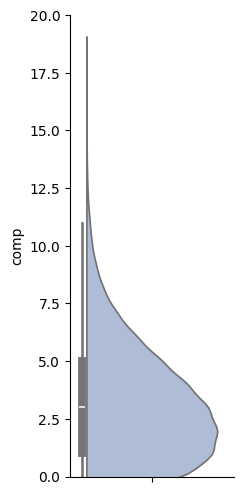

In [67]:
c = sns.light_palette('#79C')[3]
g = sns.catplot(data=results, y='comp', kind="violin", bw_adjust=2, split=True, color=c)
ax = g.axes[0,0]
ax.invert_xaxis()
ax.set_ylim((-0, 20))
g.fig.set_figwidth(2)

## plot individual speeches

In [68]:
def plotSpeech(speech_id):
    mask = results['speech_id']==speech_id
    ys = results.loc[mask, 'comp']

    _, l_fi = ys.index.values[0].rsplit(':', 1)
    _, l_la = ys.index.values[-1].rsplit(':', 1)
    author = results.loc[mask, 'author'].iloc[0]
    work = results.loc[mask, 'work'].iloc[0]
    title = f"{author} {work} {l_fi}-{l_la}"

    if '.' in l_fi:
        _, l_fi = l_fi.rsplit('.', 1)
    l_fi = int(l_fi)
    xs = np.arange(l_fi, l_fi+len(ys))

    avg = results['comp'].mean()
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(xs, ys)
    ax.axhline(avg, color=sns.light_palette('#79C')[3], ls='--')
    ax.set_ylabel('rolling composite score')
    ax.set_xlabel('line')
    ax.set_ylim((0,20))
    ax.set_title(title)
    return fig

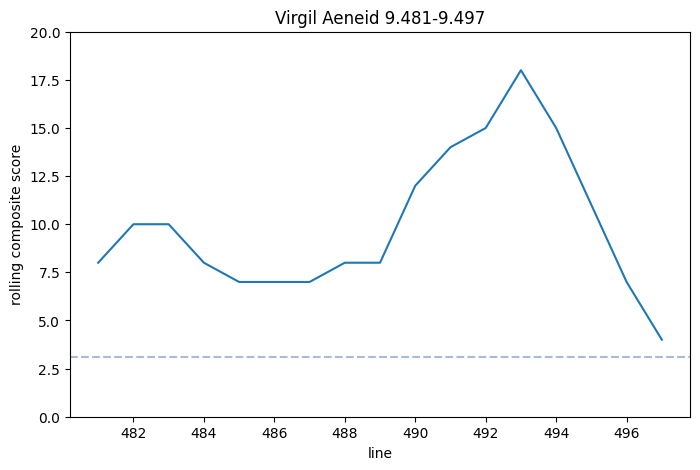

In [69]:
fig = plotSpeech('1758')
plt.show(fig)

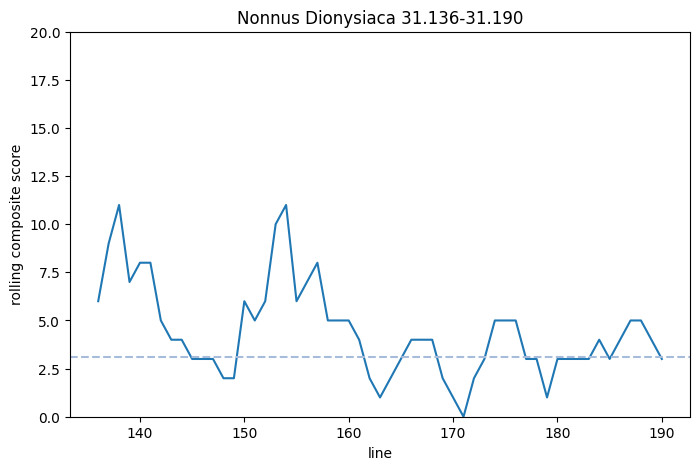

In [70]:
fig = plotSpeech('3496')
plt.show(fig)

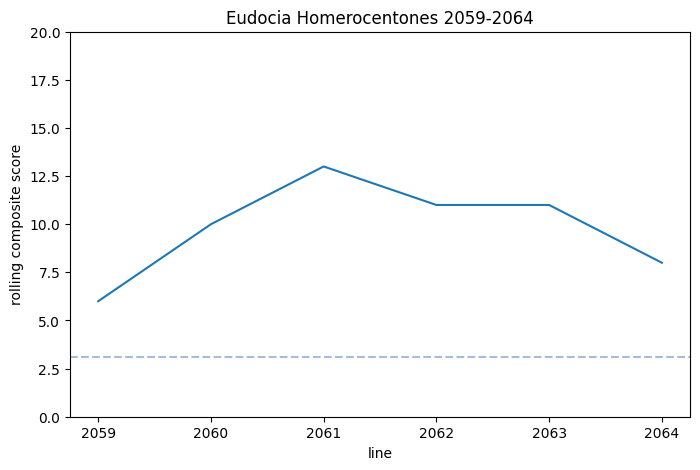

In [79]:
fig = plotSpeech('4548')
plt.show(fig)


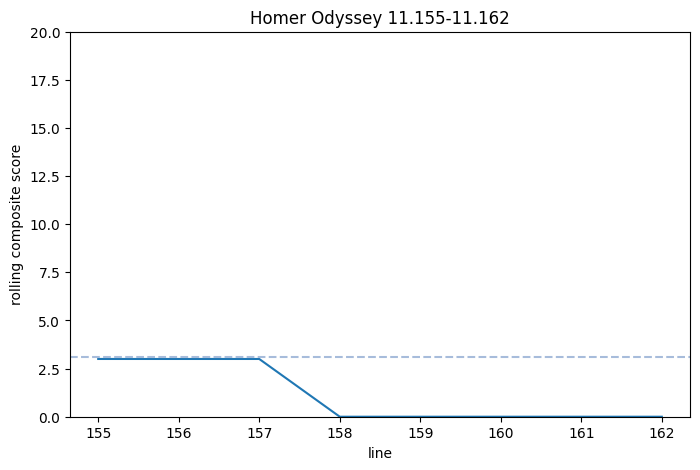

In [80]:
fig = plotSpeech('946')
plt.show(fig)

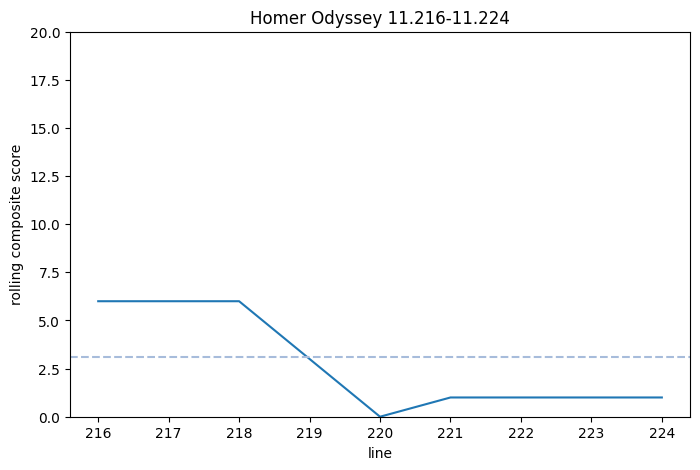

In [81]:
fig = plotSpeech('950')
plt.show(fig)

In [ ]:
fig = plotSpeech('950')
plt.show(fig)

In [ ]:
fig = plotSpeech('243')
plt.show(fig)

In [ ]:
fig = plotSpeech('1060')
plt.show(fig)

In [ ]:
fig = plotSpeech('963')
plt.show(fig)

In [ ]:
fig = plotSpeech('3332')
plt.show(fig)

In [ ]:
fig = plotSpeech('4312')
plt.show(fig)